In [3]:
# ML Data Extraction Prototype
# This notebook will connect to the database, extract and join the tables needed
# to begin feature engineering for the next-race prediction model.

# 1. Imports and engine setup
import pandas as pd
from sqlalchemy import create_engine, text
from Data_Import.database import get_engine

# Create SQLAlchemy engine
engine = get_engine(echo=False)

In [ ]:
# 2. Inspect available tables
with engine.connect() as conn:
    tables = conn.execute(text("SELECT table_name FROM information_schema.tables WHERE table_schema='public';")).fetchall()
tables_list = [t[0] for t in tables]
print("Available tables:", tables_list)

Available tables: ['athlete_rankings', 'athlete', 'race_results', 'events']


In [5]:
# 3. Load raw tables into DataFrames
# Athlete dimension
athletes_df = pd.read_sql_table('athlete', engine)
# Events dimension
events_df   = pd.read_sql_table('events', engine)
# Race results fact table
results_df  = pd.read_sql_table('race_results', engine)

print(f"Athletes: {len(athletes_df)} rows")
print(f"Events: {len(events_df)} rows")
print(f"Race results: {len(results_df)} rows")

Athletes: 1921 rows
Events: 3357 rows
Race results: 63548 rows


In [6]:
# 4. Join tables for ML dataset
# Convert EventDate to datetime for feature engineering
events_df['EventDate'] = pd.to_datetime(events_df['EventDate'])
# Merge results with events and athletes
ml_df = (
    results_df
    .merge(events_df, on='EventID', how='left')
    .merge(athletes_df, left_on='athlete_id', right_on='athlete_id', how='left')
)

print(f"ML dataset shape: {ml_df.shape}")
ml_df.head()

ML dataset shape: (63548, 28)


,athlete_id,EventID,ProgID,Program,CategoryName_x,EventSpecifications_x,Position,TotalTime,SwimTime,T1,...,EventSpecifications_y,full_name,gender,country,age,category_to,category_coach,category_athlete,category_medical,category_paratriathlete
0,173756,194854,674111,Elite Men,World Cup,"Triathlon, Standard",12,01:40:24,00:17:35,00:00:45,...,"Triathlon, Standard",Igor Dupuis,male,France,29.0,False,False,True,False,False
1,173756,194862,672520,Elite Men,Continental Cup,Sprint,2,00:50:12,00:08:35,00:00:39,...,Sprint,Igor Dupuis,male,France,29.0,False,False,True,False,False
2,173756,183778,635371,Elite Men,World Cup,"Triathlon, Sprint",26,00:57:59,00:08:41,00:00:57,...,"Triathlon, Sprint",Igor Dupuis,male,France,29.0,False,False,True,False,False
3,173756,185646,631878,Elite Men,World Cup,"Triathlon, Standard",11,01:47:41,00:17:10,00:00:34,...,"Triathlon, Standard",Igor Dupuis,male,France,29.0,False,False,True,False,False
4,173756,184450,635212,Elite Men,Continental Cup,"Triathlon, Sprint",7,00:55:07,00:09:58,00:01:13,...,"Triathlon, Sprint",Igor Dupuis,male,France,29.0,False,False,True,False,False


In [13]:
# 5. DNF Handling & Feature Engineering

# A. Flag DNF/DNS rows
ml_df['DNF_flag'] = ml_df['TotalTime'].isin(['DNF', 'DNS']).astype(int)

# B. Recent DNF rates per athlete (rolling window)
ml_df = ml_df.sort_values(['athlete_id', 'EventDate'])
ml_df['recent_5_DNF_rate'] = (
    ml_df.groupby('athlete_id')['DNF_flag']
    .rolling(window=5, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

# C. Filter for rows with a valid TotalTime for regression/classification models
ml_df_valid = ml_df[ml_df['TotalTime'].str.match(r'^\d{2}:\d{2}:\d{2}$', na=False)].copy()

print(f"ML dataset (non-DNF rows): {ml_df_valid.shape}")

ML dataset (non-DNF rows): (57809, 30)


In [14]:
# 6. Save or cache the cleaned DataFrames for next steps
ml_df.to_parquet('data/ml_raw_dataset_with_dnf.parquet', index=False)
ml_df_valid.to_parquet('data/ml_raw_dataset_valid_only.parquet', index=False)
print("ML datasets saved: with DNF indicators and valid-only rows.")

ML datasets saved: with DNF indicators and valid-only rows.


CategoryName_x             6927
CategoryName_y             6927
Venue                      4368
RunTime                     181
age                          16
EventSpecifications_x        15
EventSpecifications_y        15
T1                           14
SwimTime                     14
BikeTime                      5
T2                            5
Program                       0
athlete_id                    0
EventID                       0
EventName                     0
Position                      0
TotalTime                     0
ProgID                        0
Country                       0
full_name                     0
gender                        0
EventDate                     0
country                       0
category_to                   0
category_coach                0
category_athlete              0
category_medical              0
category_paratriathlete       0
DNF_flag                      0
recent_5_DNF_rate             0
dtype: int64
athlete_id                 

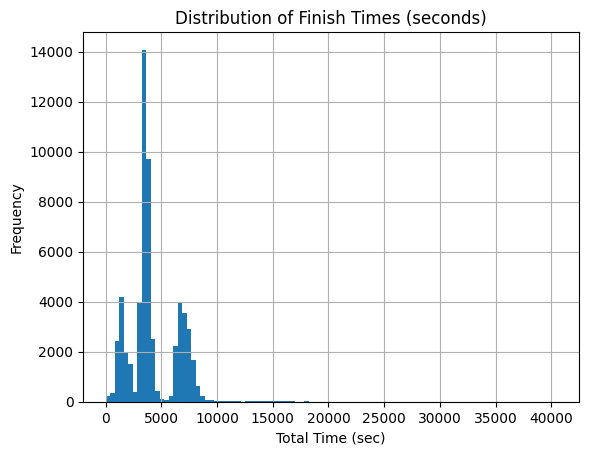

In [16]:
# Use only valid rows for EDA on finish time
eda_df = ml_df_valid.copy()

# 6.1. Null/NA check
print(eda_df.isnull().sum().sort_values(ascending=False))

# 6.2. Data types and summary
print(eda_df.dtypes)
print(eda_df.describe(include='all'))

# 6.3. Unique values per column (quick profiling)
for col in eda_df.columns:
    print(f"{col}: {eda_df[col].nunique()} unique values")

# 6.4. Quick outlier detection for finish time
import matplotlib.pyplot as plt
eda_df['TotalTime_sec'] = pd.to_timedelta(eda_df['TotalTime']).dt.total_seconds()
eda_df['TotalTime_sec'].hist(bins=100)
plt.title('Distribution of Finish Times (seconds)')
plt.xlabel('Total Time (sec)')
plt.ylabel('Frequency')
plt.show()
